# Training Transformer

### TA's Slide
[Slide](https://docs.google.com/presentation/d/1ga0d43mWyrfHjdkp7FG3iWcEKTGr8CdkifYhhi4LBY8/edit?usp=sharing)

### Description
In this assignment, we are tasked with utilizing a transformer decoder-only architecture for pretraining, with a focus on next-token prediction, applied to Pokémon images.

Please feel free to mail us if you have any questions.

ntu-ml-2025-spring-ta@googlegroups.com

# Utilities

### Download packages

In [1]:
!pip install datasets==3.3.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 26.2 MB/s eta 0:00:00
  Attempting uninstall: datasets
    Found existing installation: datasets 3.3.1
    Uninstalling datasets-3.3.1:
      Successfully uninstalled datasets-3.3.1


### Import Packages

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import AutoModelForCausalLM, GPT2Config, set_seed
from datasets import load_dataset
from typing import Dict, Any, Optional

### Check Devices

In [3]:
!nvidia-smi

Sat Apr  5 06:54:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             27W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Set Random Seed

In [4]:
set_seed(0)

# Prepare Data

### Define Dataset

In [5]:
from typing import List, Tuple, Union
import torch
from torch.utils.data import Dataset

class PixelSequenceDataset(Dataset):
    def __init__(self, data: List[List[int]], mode: str = "train"):
        """
        A dataset class for handling pixel sequences.

        Args:
            data (List[List[int]]): A list of sequences, where each sequence is a list of integers.
            mode (str): The mode of operation, either "train", "dev", or "test".
                - "train": Returns (input_ids, labels) where input_ids are sequence[:-1] and labels are sequence[1:].
                - "dev": Returns (input_ids, labels) where input_ids are sequence[:-160] and labels are sequence[-160:].
                - "test": Returns only input_ids, as labels are not available.
        """
        self.data = data
        self.mode = mode

    def __len__(self) -> int:
        """Returns the total number of sequences in the dataset."""
        return len(self.data)

    def __getitem__(self, idx: int) -> Union[Tuple[torch.Tensor, torch.Tensor], torch.Tensor]:
        """
        Fetches a sequence from the dataset and processes it based on the mode.

        Args:
            idx (int): The index of the sequence.

        Returns:
            - If mode == "train": Tuple[torch.Tensor, torch.Tensor] -> (input_ids, labels)
            - If mode == "dev": Tuple[torch.Tensor, torch.Tensor] -> (input_ids, labels)
            - If mode == "test": torch.Tensor -> input_ids
        """
        sequence = self.data[idx]

        if self.mode == "train":
            input_ids = torch.tensor(sequence[:-1], dtype=torch.long)
            labels = torch.tensor(sequence[1:], dtype=torch.long)
            return input_ids, labels

        elif self.mode == "dev":
            input_ids = torch.tensor(sequence[:-160], dtype=torch.long)
            labels = torch.tensor(sequence[-160:], dtype=torch.long)
            return input_ids, labels

        elif self.mode == "test":
            input_ids = torch.tensor(sequence, dtype=torch.long)
            return input_ids

        raise ValueError(f"Invalid mode: {self.mode}. Choose from 'train', 'dev', or 'test'.")

### Download Dataset & Prepare Dataloader

In [6]:
# Load the pokemon dataset from Hugging Face Hub
pokemon_dataset = load_dataset("lca0503/ml2025-hw4-pokemon")

# Load the colormap from Hugging Face Hub
colormap = list(load_dataset("lca0503/ml2025-hw4-colormap")["train"]["color"])

# Define number of classes
num_classes = len(colormap)

# Define batch size
batch_size = 16

# === Prepare Dataset and DataLoader for Training ===
train_dataset: PixelSequenceDataset = PixelSequenceDataset(
    pokemon_dataset["train"]["pixel_color"], mode="train"
)
train_dataloader: DataLoader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

# === Prepare Dataset and DataLoader for Validation ===
dev_dataset: PixelSequenceDataset = PixelSequenceDataset(
    pokemon_dataset["dev"]["pixel_color"], mode="dev"
)
dev_dataloader: DataLoader = DataLoader(
    dev_dataset, batch_size=batch_size, shuffle=False
)

# === Prepare Dataset and DataLoader for Testing ===
test_dataset: PixelSequenceDataset = PixelSequenceDataset(
    pokemon_dataset["test"]["pixel_color"], mode="test"
)
test_dataloader: DataLoader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

README.md:   0%|          | 0.00/501 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/175k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/23.4k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/15.4k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/632 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/80 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/80 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/297 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.11k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/167 [00:00<?, ? examples/s]

### Visualization

In [7]:
def pixel_to_image(pixel_color: List[int], colormap: List[List[int]]) -> Image.Image:
    """
    Converts a list of pixel indices into a 20x20 RGB image using a colormap.

    Args:
        pixel_color (List[int]): A list of pixel indices representing colors.
        colormap (List[List[int]]): A list where each index maps to an RGB color [R, G, B].

    Returns:
        Image.Image: A PIL Image object representing the reconstructed image.
    """
    # Ensure the pixel_color list has at least 400 elements (pad with 0s if needed)
    while len(pixel_color) < 400:
        pixel_color.append(0)

    # Map pixel indices to actual RGB colors using the colormap
    pixel_data = [colormap[pixel] for pixel in pixel_color]

    # Convert to numpy array and reshape to 20x20x3 (RGB image)
    image_array = np.array(pixel_data, dtype=np.uint8).reshape(20, 20, 3)

    # Create a PIL Image from the array
    image = Image.fromarray(image_array)

    return image

def show_images(images: List[Image.Image]) -> None:
    """
    Displays a grid of up to 96 images using Matplotlib.

    Args:
        images (List[Image.Image]): A list of PIL Image objects to display.

    Returns:
        None
    """
    num_images = min(96, len(images))  # Limit to 96 images

    # Set up the figure size and grid layout (6 rows, 16 columns)
    fig, axes = plt.subplots(6, 16, figsize=(16, 6))
    axes = axes.flatten()  # Flatten to make iteration easier

    # Loop through images and display each one in the grid
    for i, ax in enumerate(axes):
        if i < num_images:
            ax.imshow(images[i])
            ax.axis('off')  # Hide axis
        else:
            ax.axis('off')  # Hide unused subplots

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

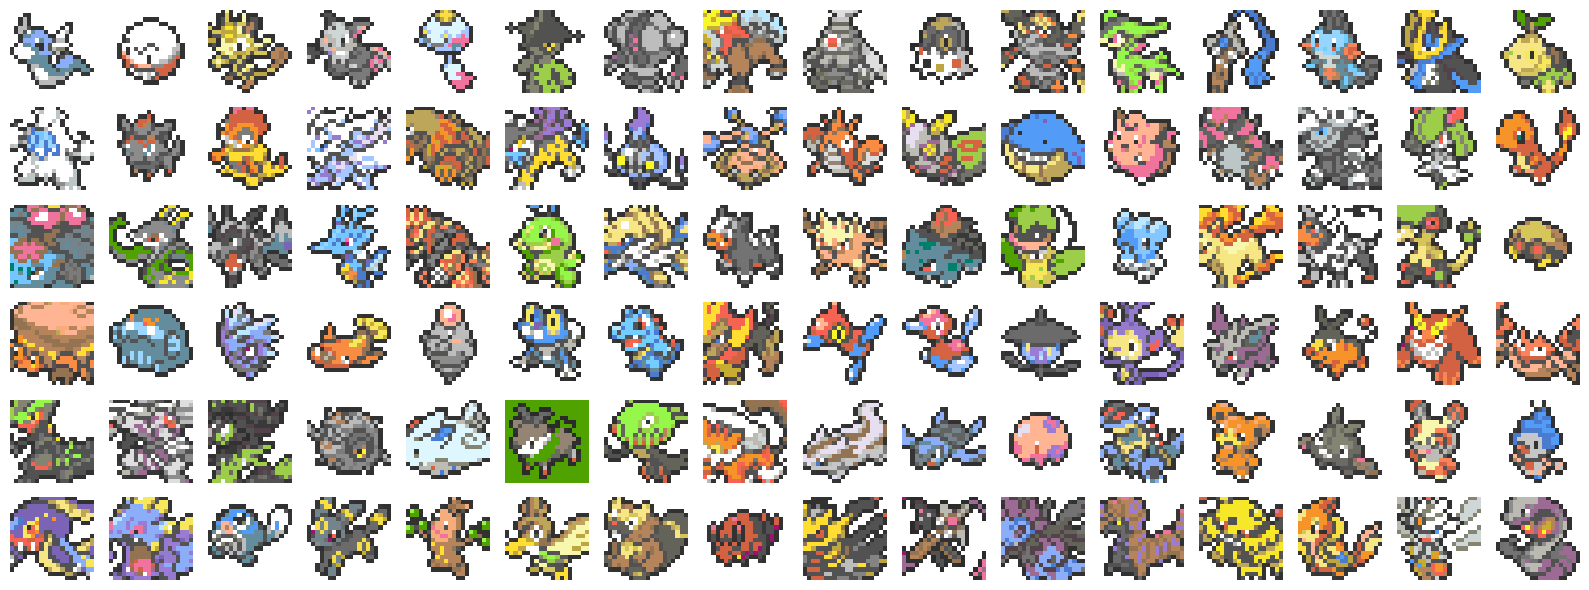

In [8]:
# Visualize train images
train_images = [pixel_to_image(data["pixel_color"], colormap) for data in pokemon_dataset["train"]]
show_images(train_images)

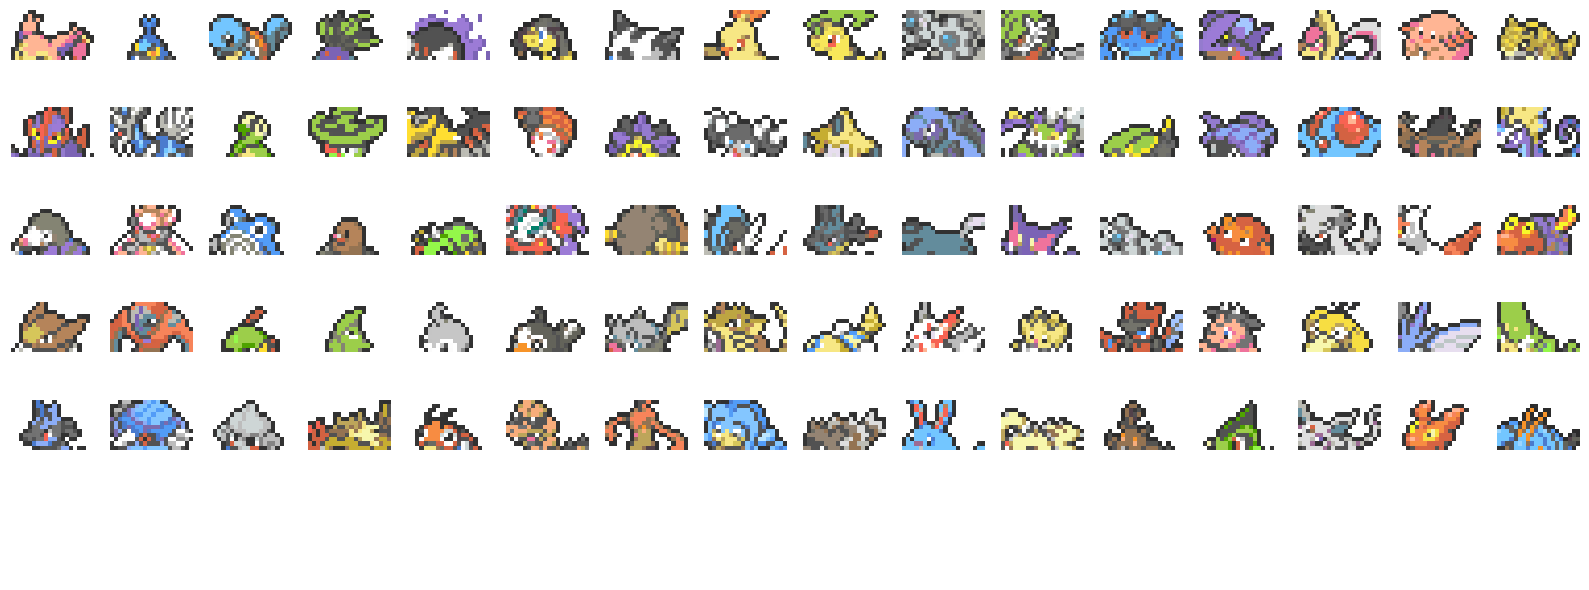

In [9]:
# Visualize test images
test_images = [pixel_to_image(data["pixel_color"], colormap) for data in pokemon_dataset["test"]]
show_images(test_images)

# Prepare Model

### Model Configuration
Here, we define the model configuration, including the architecture and key hyperparameters such as the number of attention heads, layers, embedding size, and more.
*   Hint 1: Adjust hyperparameters here for improved performance.
*   Hint 2: Experiment with different model architectures, such as Llama, Mistral, or Qwen, to enhance performance.
  * [LlamaConfig](https://huggingface.co/docs/transformers/model_doc/llama#transformers.LlamaConfig)
  * [MistralConfig](https://huggingface.co/docs/transformers/model_doc/mistral#transformers.MistralConfig)
  * [Qwen2Config](https://huggingface.co/docs/transformers/model_doc/qwen2#transformers.Qwen2Config)


In [10]:
# Define GPT-2 model configuration as a dictionary
gpt2_config = {
    "activation_function": "gelu_new",    # Activation function used in the model
    "architectures": ["GPT2LMHeadModel"],  # Specifies the model type
    "attn_pdrop": 0.1,            # Dropout rate for attention layers
    "embd_pdrop": 0.1,            # Dropout rate for embeddings
    "initializer_range": 0.02,        # Standard deviation for weight initialization
    "layer_norm_epsilon": 1e-05,       # Small constant to improve numerical stability in layer norm
    "model_type": "gpt2",           # Type of model
    "n_ctx": 128,               # Context size (maximum sequence length)
    "n_embd": 64,              # Embedding size
    "n_head": 2,               # Number of attention heads
    "n_layer": 2,              # Number of transformer layers
    "n_positions": 400,           # Maximum number of token positions
    "resid_pdrop": 0.1,           # Dropout rate for residual connections
    "vocab_size": num_classes,       # Number of unique tokens in vocabulary
    "pad_token_id": None,          # Padding token ID (None means no padding token)
    "eos_token_id": None,          # End-of-sequence token ID (None means not explicitly defined)
}

# Load GPT-2 model configuration from dictionary
config = GPT2Config.from_dict(gpt2_config)

### Load Model

In [11]:
# Load the model using the configuration defined above
model = AutoModelForCausalLM.from_config(config)

print(model)

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Trainable Parameters: {trainable_params:,}")

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(167, 64)
    (wpe): Embedding(400, 64)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-1): 2 x GPT2Block(
        (ln_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=192, nx=64)
          (c_proj): Conv1D(nf=64, nx=64)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=256, nx=64)
          (c_proj): Conv1D(nf=64, nx=256)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=64, out_features=167, bias=False)
)
Trainable Parameters: 136,384


# Train and Inference

### Training Arguments
Here, we define the number of epochs for training, the learning rate, the optimizer, and the loss function.
*   Hint 3: Adjust the number of epochs and learning rate here to improve performance.

In [12]:
# Training Parameters
epochs = 50                                      # Number of training epochs
learning_rate = 1e-3                                 # Learning rate for optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")     # Check if CUDA is available for GPU
save_dir = "checkpoints"                               # Directory to save model checkpoints

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()                          # Loss function for classification tasks
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.1) # AdamW optimizer with weight decay

### Save Model Function

In [13]:
def save_model(model: torch.nn.Module, optimizer: torch.optim.Optimizer, epoch: int, loss: float, save_dir: str, filename: str = "best_model.pth") -> None:
    """
    Saves the model state, optimizer state, current epoch, and loss to a specified directory.

    Args:
        model (torch.nn.Module): The PyTorch model to be saved.
        optimizer (torch.optim.Optimizer): The optimizer whose state will be saved.
        epoch (int): The current epoch number (used for checkpointing).
        loss (float): The current loss value to track model performance.
        save_dir (str): The directory where the model checkpoint will be saved.
        filename (str, optional): The name of the file to save the model. Defaults to "best_model.pth".

    Returns:
        None
    """
    # Construct the full path for saving the model checkpoint
    save_path = os.path.join(save_dir, filename)

    # Save the model, optimizer state, and additional metadata (epoch and loss)
    torch.save({
        'epoch': epoch + 1,                # Save epoch + 1 for easier tracking
        'model_state_dict': model.state_dict(),       # Save model weights
        'optimizer_state_dict': optimizer.state_dict(),  # Save optimizer state (important for resuming training)
        'loss': loss                     # Save the current loss value
    }, save_path)

    # Print a confirmation message indicating the model has been saved
    print(f"Model saved at {save_path} (Loss: {loss:.4f}, Epoch: {epoch + 1})")

### Train

We save the checkpoint with the lowest training loss since validation set reconstruction accuracy doesn't directly reflect the model's image generation quality.
*   Hint 4: Train a classifier to check if an image looks like a Pokémon or not. (Optional)

In [14]:
# Create save directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)
# Initialize best loss as positive infinity for comparison during model checkpointing
best_loss: float = float('inf')
# Move model to the appropriate device (GPU or CPU)
model.to(device)

# Training Loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0  # Initialize the epoch loss

    # Iterate over training data batches
    for input_ids, labels in tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
        input_ids, labels = input_ids.to(device), labels.to(device)  # Move data to the same device as the model

        # Forward pass through the model to get logits (output probabilities)
        outputs = model(input_ids=input_ids).logits.view(-1, config.vocab_size)
        labels = labels.view(-1)  # Flatten labels to match logits shape

        # Calculate loss using CrossEntropyLoss
        loss = criterion(outputs, labels)

        # Backpropagation and optimizer step
        optimizer.zero_grad()  # Reset gradients to zero
        loss.backward()     # Compute gradients
        optimizer.step()     # Update model weights

        # Accumulate the loss for the epoch
        epoch_loss += loss.item()

    # Compute average epoch loss
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_epoch_loss:.4f}")

    # Evaluation Loop (Validation)
    model.eval()      # Set the model to evaluation mode (disables dropout, etc.)
    total_accuracy = 0  # Initialize total accuracy
    num_batches = 0   # Initialize batch counter

    with torch.no_grad():  # Disable gradient calculation for validation
        # Iterate over validation data batches
        for inputs, labels in tqdm(dev_dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)  # Move validation data to device
            attention_mask = torch.ones_like(inputs)          # Attention mask to ensure valid token positions

            # Perform batch inference using the model
            generated_outputs = model.generate(inputs, attention_mask=attention_mask, max_length=400)

            # Extract the last 160 tokens from generated outputs and labels
            generated_outputs = generated_outputs[:, -160:]

            # Calculate accuracy for the batch
            accuracy = (generated_outputs == labels).float().mean().item()
            total_accuracy += accuracy
            num_batches += 1

    # Compute average reconstruction accuracy for the epoch
    avg_accuracy = total_accuracy / num_batches
    print(f"Epoch {epoch + 1}/{epochs}, Reconstruction Accuracy: {avg_accuracy:.4f}")

    # If the current epoch loss is better (lower) than the best loss, save the model
    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss                   # Update best loss
        save_model(model, optimizer, epoch, best_loss, save_dir)  # Save the model with the best loss

Training Epoch 1/50: 100%|██████████| 40/40 [00:01<00:00, 37.31it/s]


Epoch 1/50, Loss: 3.7599


Evaluating: 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]


Epoch 1/50, Reconstruction Accuracy: 0.4102
Model saved at checkpoints/best_model.pth (Loss: 3.7599, Epoch: 1)


Training Epoch 2/50: 100%|██████████| 40/40 [00:00<00:00, 102.22it/s]


Epoch 2/50, Loss: 2.7301


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.74it/s]


Epoch 2/50, Reconstruction Accuracy: 0.4073
Model saved at checkpoints/best_model.pth (Loss: 2.7301, Epoch: 2)


Training Epoch 3/50: 100%|██████████| 40/40 [00:00<00:00, 100.82it/s]


Epoch 3/50, Loss: 2.4344


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]


Epoch 3/50, Reconstruction Accuracy: 0.4062
Model saved at checkpoints/best_model.pth (Loss: 2.4344, Epoch: 3)


Training Epoch 4/50: 100%|██████████| 40/40 [00:00<00:00, 101.40it/s]


Epoch 4/50, Loss: 2.2723


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]


Epoch 4/50, Reconstruction Accuracy: 0.4121
Model saved at checkpoints/best_model.pth (Loss: 2.2723, Epoch: 4)


Training Epoch 5/50: 100%|██████████| 40/40 [00:00<00:00, 101.76it/s]


Epoch 5/50, Loss: 2.1674


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.77it/s]


Epoch 5/50, Reconstruction Accuracy: 0.4020
Model saved at checkpoints/best_model.pth (Loss: 2.1674, Epoch: 5)


Training Epoch 6/50: 100%|██████████| 40/40 [00:00<00:00, 102.10it/s]


Epoch 6/50, Loss: 2.0949


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.77it/s]


Epoch 6/50, Reconstruction Accuracy: 0.4079
Model saved at checkpoints/best_model.pth (Loss: 2.0949, Epoch: 6)


Training Epoch 7/50: 100%|██████████| 40/40 [00:00<00:00, 101.29it/s]


Epoch 7/50, Loss: 2.0343


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.77it/s]


Epoch 7/50, Reconstruction Accuracy: 0.3969
Model saved at checkpoints/best_model.pth (Loss: 2.0343, Epoch: 7)


Training Epoch 8/50: 100%|██████████| 40/40 [00:00<00:00, 102.15it/s]


Epoch 8/50, Loss: 1.9855


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.76it/s]


Epoch 8/50, Reconstruction Accuracy: 0.4080
Model saved at checkpoints/best_model.pth (Loss: 1.9855, Epoch: 8)


Training Epoch 9/50: 100%|██████████| 40/40 [00:00<00:00, 101.98it/s]


Epoch 9/50, Loss: 1.9445


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]


Epoch 9/50, Reconstruction Accuracy: 0.4052
Model saved at checkpoints/best_model.pth (Loss: 1.9445, Epoch: 9)


Training Epoch 10/50: 100%|██████████| 40/40 [00:00<00:00, 102.02it/s]


Epoch 10/50, Loss: 1.9149


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.73it/s]


Epoch 10/50, Reconstruction Accuracy: 0.4016
Model saved at checkpoints/best_model.pth (Loss: 1.9149, Epoch: 10)


Training Epoch 11/50: 100%|██████████| 40/40 [00:00<00:00, 101.26it/s]


Epoch 11/50, Loss: 1.8882


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.74it/s]


Epoch 11/50, Reconstruction Accuracy: 0.4036
Model saved at checkpoints/best_model.pth (Loss: 1.8882, Epoch: 11)


Training Epoch 12/50: 100%|██████████| 40/40 [00:00<00:00, 102.59it/s]


Epoch 12/50, Loss: 1.8638


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.77it/s]


Epoch 12/50, Reconstruction Accuracy: 0.3947
Model saved at checkpoints/best_model.pth (Loss: 1.8638, Epoch: 12)


Training Epoch 13/50: 100%|██████████| 40/40 [00:00<00:00, 102.18it/s]


Epoch 13/50, Loss: 1.8406


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]


Epoch 13/50, Reconstruction Accuracy: 0.3945
Model saved at checkpoints/best_model.pth (Loss: 1.8406, Epoch: 13)


Training Epoch 14/50: 100%|██████████| 40/40 [00:00<00:00, 102.20it/s]


Epoch 14/50, Loss: 1.8236


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.77it/s]


Epoch 14/50, Reconstruction Accuracy: 0.3838
Model saved at checkpoints/best_model.pth (Loss: 1.8236, Epoch: 14)


Training Epoch 15/50: 100%|██████████| 40/40 [00:00<00:00, 102.29it/s]


Epoch 15/50, Loss: 1.7993


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.74it/s]


Epoch 15/50, Reconstruction Accuracy: 0.3622
Model saved at checkpoints/best_model.pth (Loss: 1.7993, Epoch: 15)


Training Epoch 16/50: 100%|██████████| 40/40 [00:00<00:00, 102.19it/s]


Epoch 16/50, Loss: 1.7831


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.78it/s]


Epoch 16/50, Reconstruction Accuracy: 0.3802
Model saved at checkpoints/best_model.pth (Loss: 1.7831, Epoch: 16)


Training Epoch 17/50: 100%|██████████| 40/40 [00:00<00:00, 102.31it/s]


Epoch 17/50, Loss: 1.7655


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.77it/s]


Epoch 17/50, Reconstruction Accuracy: 0.3755
Model saved at checkpoints/best_model.pth (Loss: 1.7655, Epoch: 17)


Training Epoch 18/50: 100%|██████████| 40/40 [00:00<00:00, 102.04it/s]


Epoch 18/50, Loss: 1.7521


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.87it/s]


Epoch 18/50, Reconstruction Accuracy: 0.3692
Model saved at checkpoints/best_model.pth (Loss: 1.7521, Epoch: 18)


Training Epoch 19/50: 100%|██████████| 40/40 [00:00<00:00, 101.62it/s]


Epoch 19/50, Loss: 1.7386


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]


Epoch 19/50, Reconstruction Accuracy: 0.3920
Model saved at checkpoints/best_model.pth (Loss: 1.7386, Epoch: 19)


Training Epoch 20/50: 100%|██████████| 40/40 [00:00<00:00, 102.54it/s]


Epoch 20/50, Loss: 1.7245


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]


Epoch 20/50, Reconstruction Accuracy: 0.3702
Model saved at checkpoints/best_model.pth (Loss: 1.7245, Epoch: 20)


Training Epoch 21/50: 100%|██████████| 40/40 [00:00<00:00, 101.46it/s]


Epoch 21/50, Loss: 1.7116


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]


Epoch 21/50, Reconstruction Accuracy: 0.3713
Model saved at checkpoints/best_model.pth (Loss: 1.7116, Epoch: 21)


Training Epoch 22/50: 100%|██████████| 40/40 [00:00<00:00, 102.14it/s]


Epoch 22/50, Loss: 1.7029


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]


Epoch 22/50, Reconstruction Accuracy: 0.3825
Model saved at checkpoints/best_model.pth (Loss: 1.7029, Epoch: 22)


Training Epoch 23/50: 100%|██████████| 40/40 [00:00<00:00, 101.45it/s]


Epoch 23/50, Loss: 1.6850


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]


Epoch 23/50, Reconstruction Accuracy: 0.3698
Model saved at checkpoints/best_model.pth (Loss: 1.6850, Epoch: 23)


Training Epoch 24/50: 100%|██████████| 40/40 [00:00<00:00, 101.70it/s]


Epoch 24/50, Loss: 1.6803


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


Epoch 24/50, Reconstruction Accuracy: 0.3460
Model saved at checkpoints/best_model.pth (Loss: 1.6803, Epoch: 24)


Training Epoch 25/50: 100%|██████████| 40/40 [00:00<00:00, 96.34it/s]


Epoch 25/50, Loss: 1.6678


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.82it/s]


Epoch 25/50, Reconstruction Accuracy: 0.3995
Model saved at checkpoints/best_model.pth (Loss: 1.6678, Epoch: 25)


Training Epoch 26/50: 100%|██████████| 40/40 [00:00<00:00, 101.97it/s]


Epoch 26/50, Loss: 1.6550


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.83it/s]


Epoch 26/50, Reconstruction Accuracy: 0.3616
Model saved at checkpoints/best_model.pth (Loss: 1.6550, Epoch: 26)


Training Epoch 27/50: 100%|██████████| 40/40 [00:00<00:00, 102.30it/s]


Epoch 27/50, Loss: 1.6456


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.77it/s]


Epoch 27/50, Reconstruction Accuracy: 0.3296
Model saved at checkpoints/best_model.pth (Loss: 1.6456, Epoch: 27)


Training Epoch 28/50: 100%|██████████| 40/40 [00:00<00:00, 101.29it/s]


Epoch 28/50, Loss: 1.6319


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.78it/s]


Epoch 28/50, Reconstruction Accuracy: 0.3625
Model saved at checkpoints/best_model.pth (Loss: 1.6319, Epoch: 28)


Training Epoch 29/50: 100%|██████████| 40/40 [00:00<00:00, 101.73it/s]


Epoch 29/50, Loss: 1.6220


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.75it/s]


Epoch 29/50, Reconstruction Accuracy: 0.3542
Model saved at checkpoints/best_model.pth (Loss: 1.6220, Epoch: 29)


Training Epoch 30/50: 100%|██████████| 40/40 [00:00<00:00, 101.85it/s]


Epoch 30/50, Loss: 1.6085


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]


Epoch 30/50, Reconstruction Accuracy: 0.3555
Model saved at checkpoints/best_model.pth (Loss: 1.6085, Epoch: 30)


Training Epoch 31/50: 100%|██████████| 40/40 [00:00<00:00, 102.37it/s]


Epoch 31/50, Loss: 1.5946


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.82it/s]


Epoch 31/50, Reconstruction Accuracy: 0.3487
Model saved at checkpoints/best_model.pth (Loss: 1.5946, Epoch: 31)


Training Epoch 32/50: 100%|██████████| 40/40 [00:00<00:00, 102.67it/s]


Epoch 32/50, Loss: 1.5876


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]


Epoch 32/50, Reconstruction Accuracy: 0.3582
Model saved at checkpoints/best_model.pth (Loss: 1.5876, Epoch: 32)


Training Epoch 33/50: 100%|██████████| 40/40 [00:00<00:00, 101.55it/s]


Epoch 33/50, Loss: 1.5822


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]


Epoch 33/50, Reconstruction Accuracy: 0.3045
Model saved at checkpoints/best_model.pth (Loss: 1.5822, Epoch: 33)


Training Epoch 34/50: 100%|██████████| 40/40 [00:00<00:00, 98.56it/s]


Epoch 34/50, Loss: 1.5714


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]


Epoch 34/50, Reconstruction Accuracy: 0.3557
Model saved at checkpoints/best_model.pth (Loss: 1.5714, Epoch: 34)


Training Epoch 35/50: 100%|██████████| 40/40 [00:00<00:00, 101.18it/s]


Epoch 35/50, Loss: 1.5627


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]


Epoch 35/50, Reconstruction Accuracy: 0.3619
Model saved at checkpoints/best_model.pth (Loss: 1.5627, Epoch: 35)


Training Epoch 36/50: 100%|██████████| 40/40 [00:00<00:00, 101.59it/s]


Epoch 36/50, Loss: 1.5554


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.78it/s]


Epoch 36/50, Reconstruction Accuracy: 0.3287
Model saved at checkpoints/best_model.pth (Loss: 1.5554, Epoch: 36)


Training Epoch 37/50: 100%|██████████| 40/40 [00:00<00:00, 101.58it/s]


Epoch 37/50, Loss: 1.5474


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]


Epoch 37/50, Reconstruction Accuracy: 0.3550
Model saved at checkpoints/best_model.pth (Loss: 1.5474, Epoch: 37)


Training Epoch 38/50: 100%|██████████| 40/40 [00:00<00:00, 101.98it/s]


Epoch 38/50, Loss: 1.5436


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.76it/s]


Epoch 38/50, Reconstruction Accuracy: 0.3037
Model saved at checkpoints/best_model.pth (Loss: 1.5436, Epoch: 38)


Training Epoch 39/50: 100%|██████████| 40/40 [00:00<00:00, 101.99it/s]


Epoch 39/50, Loss: 1.5356


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.72it/s]


Epoch 39/50, Reconstruction Accuracy: 0.3481
Model saved at checkpoints/best_model.pth (Loss: 1.5356, Epoch: 39)


Training Epoch 40/50: 100%|██████████| 40/40 [00:00<00:00, 102.17it/s]


Epoch 40/50, Loss: 1.5326


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]


Epoch 40/50, Reconstruction Accuracy: 0.3482
Model saved at checkpoints/best_model.pth (Loss: 1.5326, Epoch: 40)


Training Epoch 41/50: 100%|██████████| 40/40 [00:00<00:00, 102.27it/s]


Epoch 41/50, Loss: 1.5235


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.83it/s]


Epoch 41/50, Reconstruction Accuracy: 0.2978
Model saved at checkpoints/best_model.pth (Loss: 1.5235, Epoch: 41)


Training Epoch 42/50: 100%|██████████| 40/40 [00:00<00:00, 102.11it/s]


Epoch 42/50, Loss: 1.5178


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.78it/s]


Epoch 42/50, Reconstruction Accuracy: 0.3505
Model saved at checkpoints/best_model.pth (Loss: 1.5178, Epoch: 42)


Training Epoch 43/50: 100%|██████████| 40/40 [00:00<00:00, 94.78it/s] 


Epoch 43/50, Loss: 1.5120


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]


Epoch 43/50, Reconstruction Accuracy: 0.2980
Model saved at checkpoints/best_model.pth (Loss: 1.5120, Epoch: 43)


Training Epoch 44/50: 100%|██████████| 40/40 [00:00<00:00, 101.87it/s]


Epoch 44/50, Loss: 1.5031


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]


Epoch 44/50, Reconstruction Accuracy: 0.3484
Model saved at checkpoints/best_model.pth (Loss: 1.5031, Epoch: 44)


Training Epoch 45/50: 100%|██████████| 40/40 [00:00<00:00, 101.88it/s]


Epoch 45/50, Loss: 1.4980


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]


Epoch 45/50, Reconstruction Accuracy: 0.3383
Model saved at checkpoints/best_model.pth (Loss: 1.4980, Epoch: 45)


Training Epoch 46/50: 100%|██████████| 40/40 [00:00<00:00, 102.34it/s]


Epoch 46/50, Loss: 1.4917


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]


Epoch 46/50, Reconstruction Accuracy: 0.3405
Model saved at checkpoints/best_model.pth (Loss: 1.4917, Epoch: 46)


Training Epoch 47/50: 100%|██████████| 40/40 [00:00<00:00, 101.72it/s]


Epoch 47/50, Loss: 1.4945


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.77it/s]


Epoch 47/50, Reconstruction Accuracy: 0.3494


Training Epoch 48/50: 100%|██████████| 40/40 [00:00<00:00, 101.84it/s]


Epoch 48/50, Loss: 1.4861


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.82it/s]


Epoch 48/50, Reconstruction Accuracy: 0.3230
Model saved at checkpoints/best_model.pth (Loss: 1.4861, Epoch: 48)


Training Epoch 49/50: 100%|██████████| 40/40 [00:00<00:00, 101.88it/s]


Epoch 49/50, Loss: 1.4842


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.82it/s]


Epoch 49/50, Reconstruction Accuracy: 0.3162
Model saved at checkpoints/best_model.pth (Loss: 1.4842, Epoch: 49)


Training Epoch 50/50: 100%|██████████| 40/40 [00:00<00:00, 102.34it/s]


Epoch 50/50, Loss: 1.4768


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]

Epoch 50/50, Reconstruction Accuracy: 0.3459
Model saved at checkpoints/best_model.pth (Loss: 1.4768, Epoch: 50)


### Inference

In [15]:
# Load the best model from the saved checkpoint
best_model_path = os.path.join(save_dir, "best_model.pth")              # Path to the best model checkpoint
checkpoint = torch.load(best_model_path, weights_only=True, map_location=device)  # Load checkpoint from the file
model.load_state_dict(checkpoint["model_state_dict"])                  # Load the model weights from checkpoint
model.eval()                                        # Set the model to evaluation mode (disables dropout, etc.)

# Testing Loop with Batch Inference
results: list = []  # List to store the generated sequences from the model

with torch.no_grad():  # Disable gradient calculations for inference
    # Iterate over test data in batches
    for inputs in tqdm(test_dataloader, desc="Generating Outputs"):
        inputs = inputs.to(device)         # Move model to the appropriate device (GPU or CPU)
        attention_mask = torch.ones_like(inputs)  # Attention mask (ensure valid token positions)

        # Generate predictions for the entire batch
        generated_outputs = model.generate(inputs, attention_mask=attention_mask, max_length=400)

        # Convert batch outputs to a list and append to results
        batch_results = generated_outputs.cpu().numpy().tolist()
        results.extend(batch_results)  # Extend the results list with batch results

# Save the results to a file
output_file: str = "reconstructed_results.txt"  # File to save the output sequences
with open(output_file, "w") as f:
    # Write each sequence to the file
    for seq in results:
        f.write(" ".join(map(str, seq)) + "\n")

print(f"Reconstructed results saved to {output_file}")  # Confirmation message

Generating Outputs: 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]

Reconstructed results saved to reconstructed_results.txt


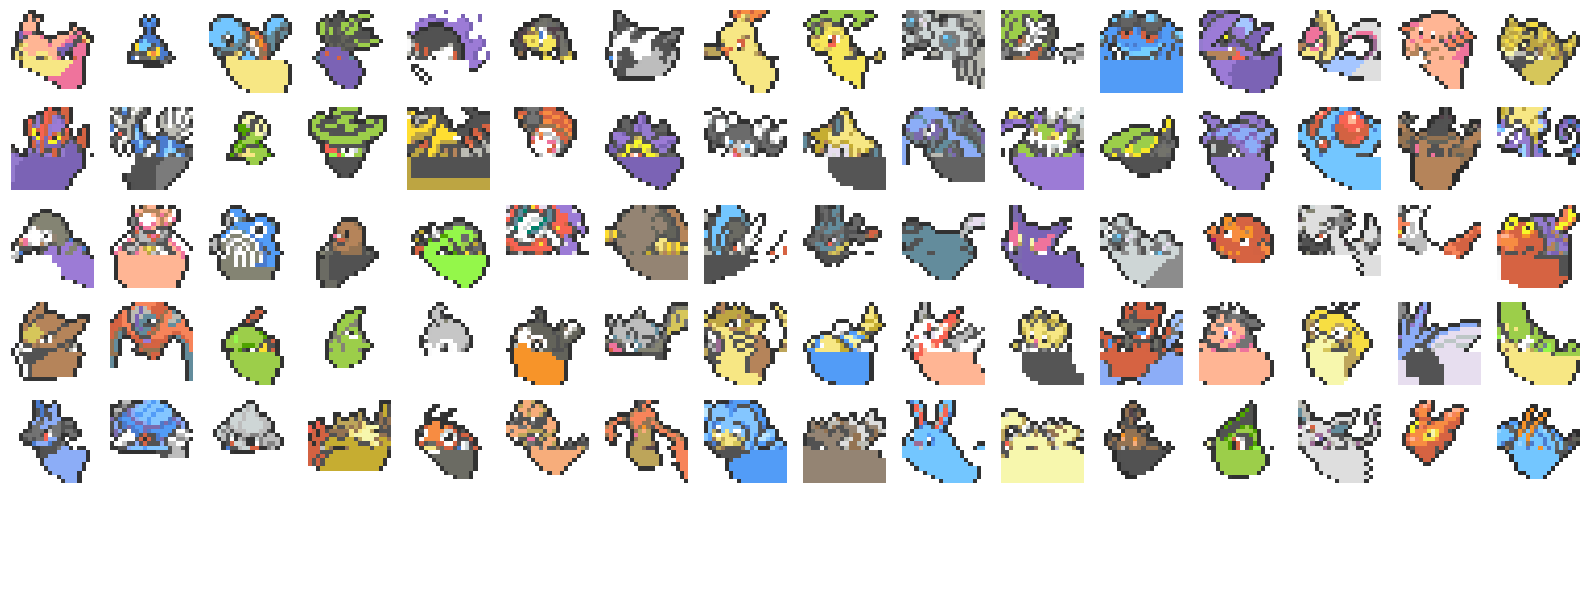

In [16]:
# Visualize generated test images
predicted_images = [pixel_to_image(sequence, colormap) for sequence in results]
show_images(predicted_images)